In [2]:
from fretbursts import *
sns = init_notebook()

In [4]:
full_fname='../data/n25c.h5'
d = loader.photon_hdf5(full_fname)

In [5]:
d.time_max

2400.0478221713915

In [6]:
d.det_t

[array([1, 0, 0, ..., 0, 0, 1], dtype=uint8)]

In [7]:
print("Detector    Counts")
print("--------   --------")
for det, count in zip(*np.unique(d.det_t, return_counts=True)):
    print("%8d   %8d" % (det, count))

Detector    Counts
--------   --------
       0   11462403
       1    8911506


//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


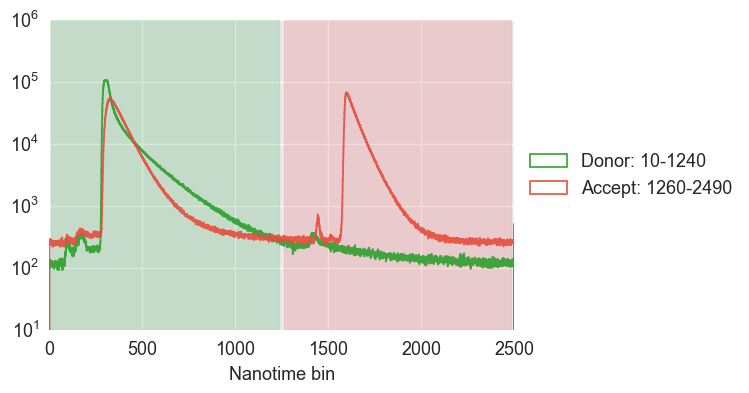

In [8]:
bpl.plot_alternation_hist(d)

In [9]:
loader.alex_apply_period(d)

# Total photons (after ALEX selection):    20,354,229
#  D  photons in D+A excitation periods:    8,903,524
#  A  photons in D+A excitation periods:   11,450,705
# D+A photons in  D  excitation period:    14,979,672
# D+A photons in  A  excitation period:     5,374,557



In [10]:
d.calc_bg(fun=bg.exp_fit, time_s=30, tail_min_us='auto', F_bg=1.7)

 - Calculating BG rates ... [DONE]


In [29]:
mask_dd = d.get_ph_mask(ph_sel=Ph_sel(Dex='Dem')) 
print(mask_dd[1:10])

[False False False False False False  True  True  True]


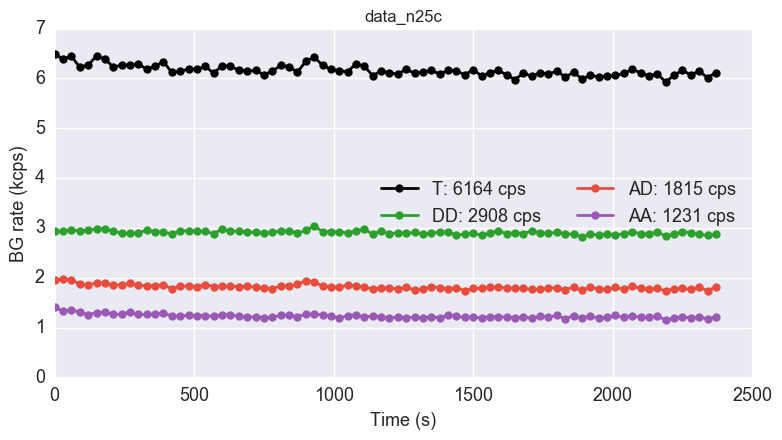

In [11]:
dplot(d, timetrace_bg)

(-50, 50)

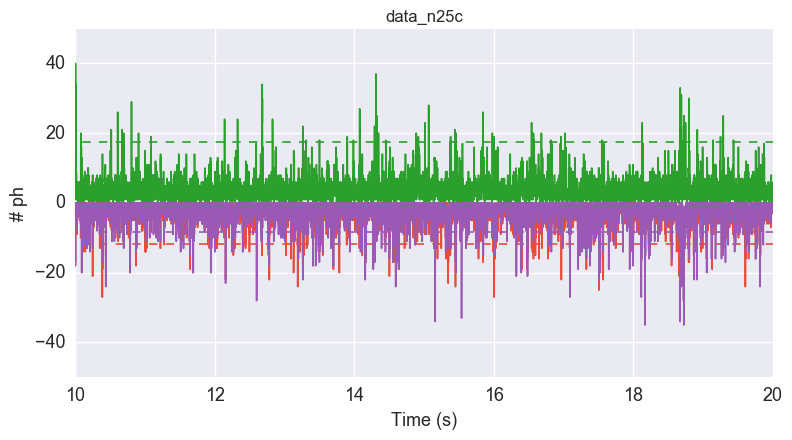

In [12]:
dplot(d, timetrace)
xlim(10, 20)
ylim(-50, 50)


In [13]:
d.burst_search()

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]


In [14]:
ph = d.get_ph_times()
ns=d.nanotimes

len(ph),len(ns[0])

(20354229, 20354229)

In [15]:
import numpy as np
print(np.mean(d.TT),len(d.TT[0]))

0.000270438029201 80


In [16]:
ds = d.select_bursts(select_bursts.naa, th1=3, computefret=False)
ds = ds.select_bursts(select_bursts.size, th1=25)
ds = ds.fuse_bursts(ms=0)

 - - - - - CHANNEL  1 - - - - 
 --> END Fused 45 bursts (1.1%, 3 iter)

 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A and FRET]


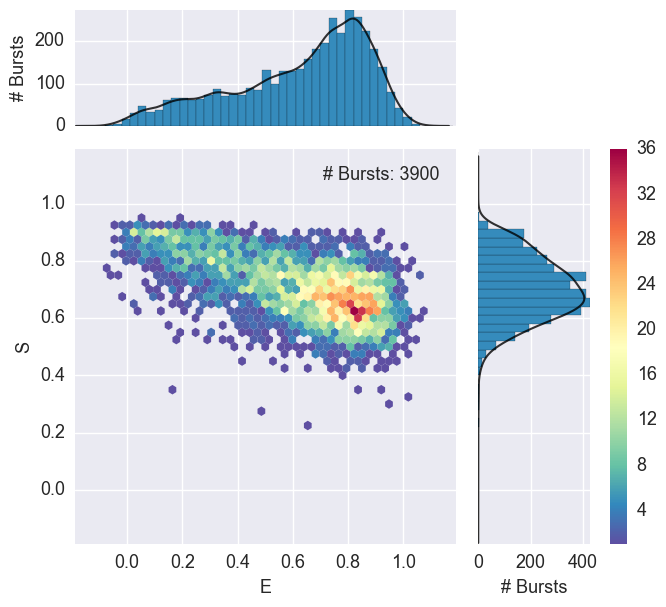

In [17]:
alex_jointplot(ds)

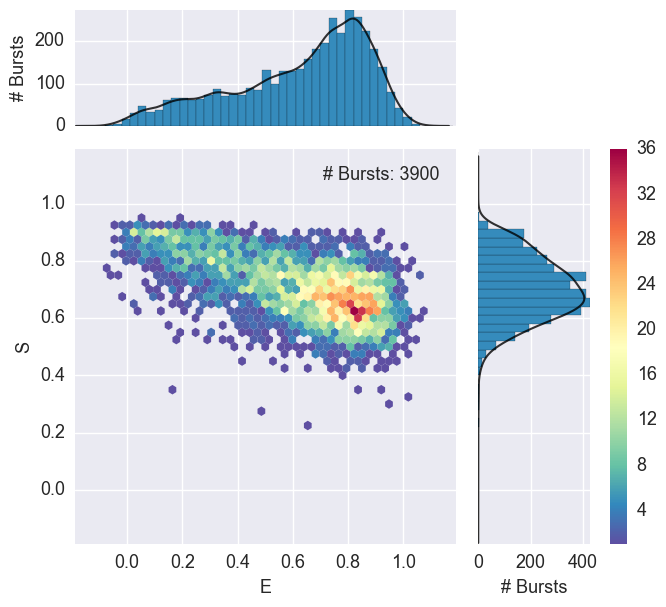

In [18]:
alex_jointplot(ds)

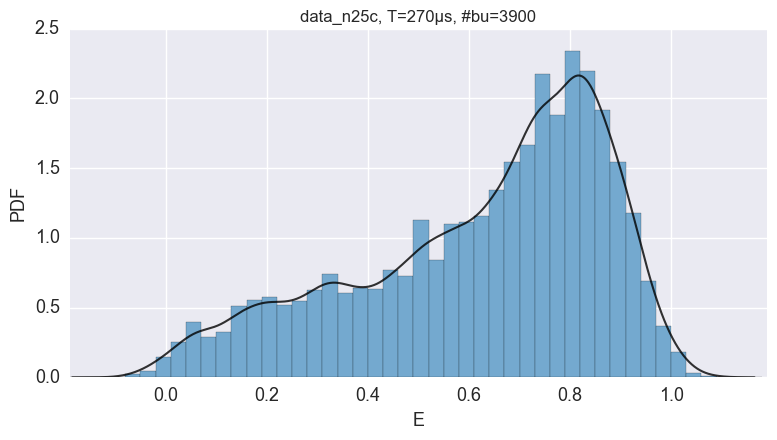

In [19]:
dplot(ds, hist_fret, show_kde=True)

In [20]:
nanotimes = d.nanotimes[0]
nanotimes_d = nanotimes[d.get_D_em()]
nanotimes_a = nanotimes[d.get_A_em()]

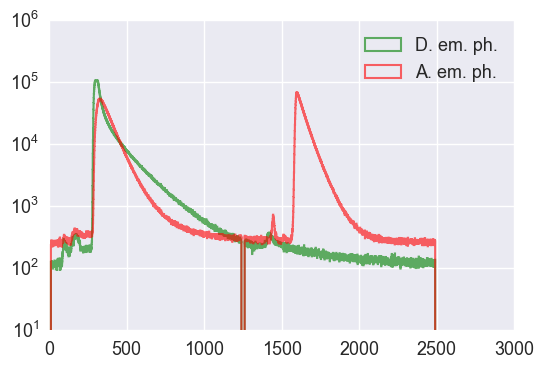

In [21]:
hist_params = dict(bins=range(3000), histtype='step', alpha=0.6, lw=1.5)
#hist(nanotimes, color='k', label='Total ph.', **hist_params)
hist(nanotimes_d, color='g', label='D. em. ph.', **hist_params)
hist(nanotimes_a, color='r', label='A. em. ph.', **hist_params)
plt.legend()
plt.yscale('log')

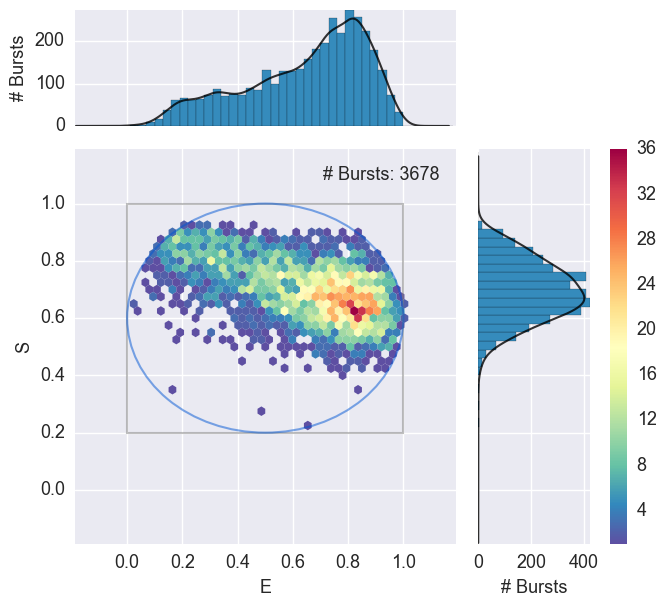

In [22]:
roi = dict(E1=0, E2=1, S1=0.2, S2=1, rect=False)
d_fret_mix = ds.select_bursts(select_bursts.ES, **roi)
g = alex_jointplot(d_fret_mix)
bpl.plot_ES_selection(g.ax_joint, **roi);

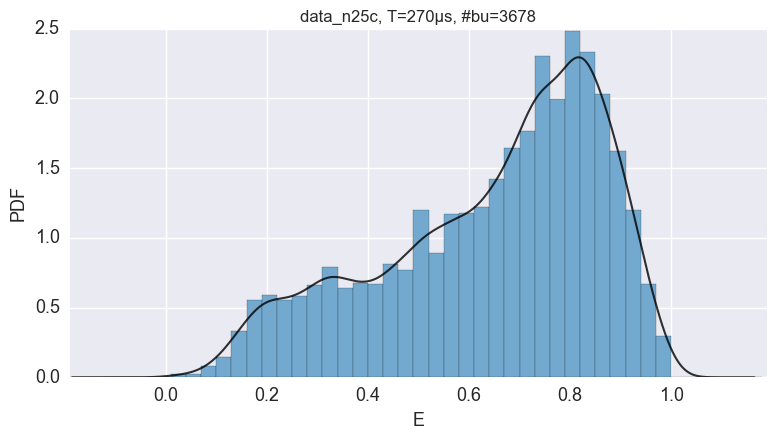

In [23]:
dplot(d_fret_mix, hist_fret, show_kde=True)

In [36]:
from fretbursts.phtools.burstsearch import Burst, Bursts
times = d.ph_times_m[0]  # timestamps array
bursts = d_fret_mix.mburst[0]
print('\nNumber of bursts:', bursts.num_bursts)
mask_dd = d.get_ph_mask(ph_sel=Ph_sel(Dex='Dem')) 
print(times[0:10])
print(mask_dd[0:10])
print(times[mask_dd[0:10]])
print(np.mean(times[mask_dd[0:10]]))


Number of bursts: 3678
[ 2237  2382  9298 10776 12153 13399 15911 27858 28262 28537]
[ True False False False False False False  True  True  True]
[ 2237 27858 28262 28537]
21723.5


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 20354229 but corresponding boolean dimension is 10
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 20354229 but corresponding boolean dimension is 10


In [38]:
len(np.linspace(0,140))

50

In [23]:
time_bin = 0.5e-3  # 0.5 ms
time_bin_clk = time_bin / ds.clk_p

sub_bursts_list = []
for burst in bursts:
    # Compute binning of current bursts
    bins = np.arange(burst.start, burst.stop + time_bin_clk, time_bin_clk)
    counts, _ = np.histogram(times[burst.istart:burst.istop+1], bins)
    
    # From `counts` in each bin, find start-stop times and indexes (sub-burst).
    # Note that start and stop are the min and max timestamps in the bin,
    # therefore they are not on the bin edges. Also the burst width is not
    # exactly equal to the bin width.
    sub_bursts_l = []
    sub_start = burst.start
    sub_istart = burst.istart
    for count in counts:
        # Let's skip bins with 0 photons
        if count == 0:
            continue
            
        sub_istop = sub_istart + count - 1
        sub_bursts_l.append(Burst(istart=sub_istart, istop=sub_istop,
                                  start=sub_start, stop=times[sub_istop]))
        
        sub_istart += count 
        sub_start = times[sub_istart]
    
    sub_bursts = Bursts.from_list(sub_bursts_l)
    assert sub_bursts.num_bursts > 0
    assert sub_bursts.width.max() < time_bin_clk
    sub_bursts_list.append(sub_bursts)

In [24]:
len(sub_bursts_list)

3763

In [25]:
d_fret_mix.num_bursts

array([3763])

In [26]:
iburst = 100
print('Sub-bursts from burst %d:' % iburst)
sub_bursts_list[iburst]

Sub-bursts from burst 100:


,istart,istop,start,stop
0,720735,720760,1480181167,1480189070
1,720761,720787,1480189312,1480197134


In [27]:
(869175247-869183230)*ds.clk_p,ds.clk_p

(-0.0004989125543722814, 6.249687515624219e-08)

In [28]:
439824-439803

21

In [29]:
nanotimes[2:9]

array([1589,  278, 1754,  282,  537,  311,  340], dtype=uint16)

In [30]:
lbursts = sub_bursts_list[0]
lbursts

,istart,istop,start,stop
0,2994,3021,7121134,7129046
1,3022,3035,7129239,7133990


In [41]:
mask_dd = d.get_ph_mask(ph_sel=Ph_sel(Dex='Dem'))   # donor excitation, donor emission
mask_ad = d.get_ph_mask(ph_sel=Ph_sel(Dex='Aem'))   # donor excitation, acceptor emission
mask_aa = d.get_ph_mask(ph_sel=Ph_sel(Aex='Aem'))   # acceptor excitation, acceptor emission
from fretbursts.phtools.burstsearch import count_ph_in_bursts
gamma=0.34
beta=1.42
DexDirAem=0.08
Dch2Ach=0.07 

counts_dd = count_ph_in_bursts(bursts, mask_dd)
counts_ad = count_ph_in_bursts(bursts, mask_ad)
counts_aa = count_ph_in_bursts(bursts, mask_aa)
e=((counts_ad *(1-DexDirAem)-Dch2Ach*counts_dd)/ ((gamma-\
                            Dch2Ach)*counts_dd + (1-DexDirAem)*counts_ad)).tolist()    
# bursts.num_burst
len(e)

3763

In [32]:
import fretbursts
l=fretbursts.burstlib_ext.calc_mean_lifetime(d_fret_mix,250,1200,ph_sel=Ph_sel(Dex='DAem'))

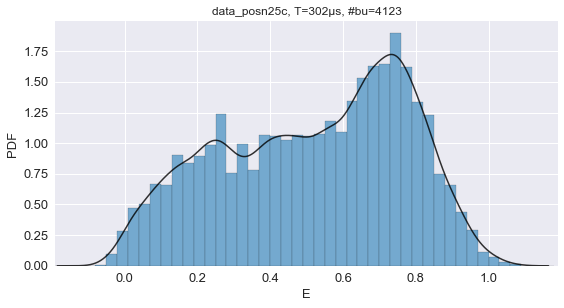

In [33]:
dplot(ds, hist_fret, show_kde=True)

In [34]:
lt=((l[0]*2.5e-2)-2.1)/4.1
gamma=0.34        
beta=1.42
DexDirAem=0.08
Dch2Ach=0.07 
fE=fretbursts.fretmath.correct_E_gamma_leak_dir(ds.E[0],gamma, leakage=Dch2Ach, dir_ex_t=DexDirAem)

(array([   2.,    2.,    3.,    4.,    4.,    6.,    3.,    7.,    7.,
          11.,   12.,   12.,   22.,   35.,   22.,   28.,   46.,   38.,
          40.,   57.,   64.,   40.,   71.,   58.,   55.,   50.,   59.,
          69.,   51.,   64.,   92.,   67.,  105.,   87.,  111.,  100.,
          76.,  143.,  124.,  135.,  151.,  202.,  230.,  257.,  264.,
         227.,  208.,  134.,   81.,   27.]),
 array([-0.00547645,  0.01391502,  0.03330649,  0.05269796,  0.07208944,
         0.09148091,  0.11087238,  0.13026385,  0.14965532,  0.1690468 ,
         0.18843827,  0.20782974,  0.22722121,  0.24661268,  0.26600416,
         0.28539563,  0.3047871 ,  0.32417857,  0.34357004,  0.36296152,
         0.38235299,  0.40174446,  0.42113593,  0.4405274 ,  0.45991888,
         0.47931035,  0.49870182,  0.51809329,  0.53748476,  0.55687624,
         0.57626771,  0.59565918,  0.61505065,  0.63444212,  0.6538336 ,
         0.67322507,  0.69261654,  0.71200801,  0.73139948,  0.75079096,
         0.77018

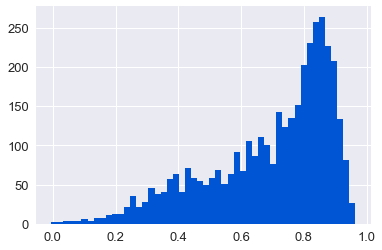

In [35]:
plt.hist(e,50)

(array([   1.,    0.,    3.,    4.,    5.,    0.,    0.,    1.,    9.,
          16.,    5.,    8.,   10.,   15.,   28.,   13.,   15.,   15.,
          31.,   27.,   24.,   34.,   38.,   32.,   49.,   54.,   43.,
          53.,   56.,   69.,   91.,   59.,  108.,   70.,   96.,   76.,
         103.,  130.,  139.,  143.,  156.,  167.,  213.,  255.,  330.,
         429.,  422.,  304.,  145.,   29.]),
 array([-0.70401163, -0.66943625, -0.63486087, -0.60028549, -0.56571012,
        -0.53113474, -0.49655936, -0.46198398, -0.4274086 , -0.39283323,
        -0.35825785, -0.32368247, -0.28910709, -0.25453172, -0.21995634,
        -0.18538096, -0.15080558, -0.1162302 , -0.08165483, -0.04707945,
        -0.01250407,  0.02207131,  0.05664668,  0.09122206,  0.12579744,
         0.16037282,  0.1949482 ,  0.22952357,  0.26409895,  0.29867433,
         0.33324971,  0.36782508,  0.40240046,  0.43697584,  0.47155122,
         0.5061266 ,  0.54070197,  0.57527735,  0.60985273,  0.64442811,
         0.67900

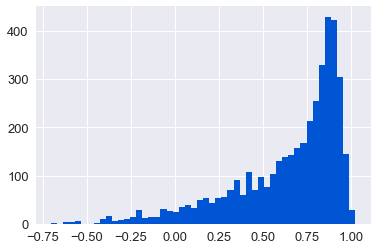

In [36]:
plt.hist(fE,50)

In [37]:

import scipy.io as sio
from array import array

Fsel=array("d")
for i in e:
    if i<0.999 and i >0.001:
        Fsel.append(i*100)
sio.savemat('fret.mat', {'fret':Fsel})

In [38]:
times = d.ph_times_m[0]

In [45]:
times[2994]

7121134

In [43]:
bursts.start

array([    7121134,    15905716,    27152458, ..., 57552889788,
       57564014550, 57589856709])

In [44]:
bursts.istart

array([    2994,     7171,    12910, ..., 26648213, 26653309, 26665552])